In [1]:
import warnings
warnings.filterwarnings("ignore")

import ee
import numpy as np
import pandas as pd
import geopandas as gpd

from tsmoothie.smoother import LowessSmoother
ee.Initialize()



In [2]:
def smooth(serie):
    serieResult = pd.Series(serie.values)
    serieindex = pd.Series(serie.index)
    smoother = LowessSmoother(smooth_fraction=0.1, iterations=2)

    dataSmooth = smoother.smooth(serieResult.values)
    return pd.Series(dataSmooth.smooth_data[0],index=serieindex)
    
def hampel_filter_pandas(input_series, window_size, n_sigmas=1):
    k = 1.4826 # Gaussian distribution
    new_series = input_series.copy()
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    rolling_median = input_series.rolling(window=2*window_size, center=True).mean()
    rolling_mad = k * input_series.rolling(window=2*window_size, center=True).apply(MAD)
    diff = (input_series - rolling_median) * -1 # toma solo las diff negativas
    indices = list(np.argwhere(diff.values > (n_sigmas * rolling_mad.values)).flatten())
    new_series[indices] = rolling_median[indices]
    return new_series#, indices

def hampel_filter_pandas_positivas(input_series, window_size, n_sigmas=1):
    k = 1.4826 
    new_series = input_series.copy()
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    rolling_median = input_series.rolling(window=2*window_size, win_type = 'gaussian', center=True).mean(std=1)
    rolling_mad = k * input_series.rolling(window=2*window_size, center=True).apply(MAD)
    diff = (input_series - rolling_median)
    indices = list(np.argwhere(diff.values > (n_sigmas * rolling_mad.values)).flatten())
    new_series[indices] = rolling_median[indices]
    return new_series

In [3]:
gdf = gpd.read_file('Frog_selsey_outwoods.geojson')
gdf.crs = "epsg:4326"
# gdf.head().plot()
table_json = gdf.__geo_interface__
table = ee.FeatureCollection(table_json['features'])

In [44]:


def cloud (image): #https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless
    image = ee.Image(image)
    clouds = ee.Image(ee.List(image.get('cloud_mask'))).select('probability')
    clean = clouds.lte(80)
    qa = image.select('QA60')
    scl = image.select('SCL').eq(4).Or(image.select('SCL').eq(5))
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    finalmask = mask.And(clean)
    return image.updateMask(finalmask)

imageCollection = ee.ImageCollection("COPERNICUS/S2")
s2Clouds = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')

s2SrWithCloudMask = ee.Join.saveFirst('cloud_mask') \
                                    .apply(**{'primary': imageCollection,'secondary': s2Clouds, \
                                    'condition': ee.Filter.equals(**{'leftField': 'system:index', 'rightField': 'system:index'})})

images = s2SrWithCloudMask.filterBounds(table).map(cloud)

# Aggregation
def aggreg (image_collection, startdate : str ,enddate : str ,timeunit : str)-> ee.ImageCollection:
    """ 
    image_collection: ee.ImageCollection
    startdate: string
    enddate: string
    timeunit: string 
    """
    start = ee.Date(startdate)
    end = ee.Date(enddate)
    timedelta = end.difference(start, timeunit)
    aggregation = 1
    def step (count):
        return start.advance(count, timeunit)
    def filter (date):
        images_g = ee.ImageCollection(image_collection.filterDate(date,ee.Date(date).advance(aggregation,timeunit)))
        return ee.Image(images_g.mean()).set('system:time_start',ee.Date(date)).set('system:date',ee.Date(date).format('dd-MM-yyyy'))
    S2_list = ee.List.sequence(0, timedelta.int(),aggregation) \
        .map(step) \
        .map(filter)

    # Check missing values
    def check (image):
        image = ee.Image(ee.Algorithms.If(ee.Image(image).bandNames(), ee.Image(image)))
        return image
    return ee.ImageCollection(S2_list).map(check, True)

S2_list_clean = aggreg(images ,'2017-01-01','2022-01-01','month') #'day' or 'month'

def data_extr (image):
    dia = ee.Date(image.get('system:time_start')).format('yyyy-MM-dd')
    ndvi = image.normalizedDifference(['B8','B4']).rename('ndvi')
    data = ndvi.reduceRegions(table,ee.Reducer.mean(),10).filterMetadata('mean','greater_than',0)
    field_name = data.aggregate_array('Field')
    farm_name = data.aggregate_array('Farm')
    crop_id = 'N/A' #data.aggregate_array('crop_id')
    ndvi_value = ee.List(data.aggregate_array('mean'))
    dia_list = ee.List.repeat(dia,ndvi_value.length())
    return ee.Feature(None).set('field',field_name,'farm',farm_name,'ndvi_mean',ndvi_value,'date',dia_list,'crop_id',crop_id)


image_list = ee.List(S2_list_clean.aggregate_array('system:time_start')).map(lambda date : ee.Date(date).format('yyyy-MM-dd')).getInfo()
list_dates = list(dict.fromkeys(image_list))
data = ee.ImageCollection(S2_list_clean).map(data_extr).getInfo()

In [45]:
display(list_dates)

['2015-07-01',
 '2015-08-01',
 '2015-09-01',
 '2015-10-01',
 '2015-11-01',
 '2015-12-01',
 '2016-01-01',
 '2016-02-01',
 '2016-03-01',
 '2016-04-01',
 '2016-05-01',
 '2016-06-01',
 '2016-07-01',
 '2016-08-01',
 '2016-09-01',
 '2016-10-01',
 '2016-11-01',
 '2016-12-01',
 '2017-01-01',
 '2017-02-01',
 '2017-03-01',
 '2017-04-01',
 '2017-05-01',
 '2017-06-01',
 '2017-07-01',
 '2017-08-01',
 '2017-09-01',
 '2017-10-01',
 '2017-11-01',
 '2017-12-01',
 '2018-01-01',
 '2018-02-01',
 '2018-03-01',
 '2018-04-01',
 '2018-05-01',
 '2018-06-01',
 '2018-07-01',
 '2018-08-01',
 '2018-09-01',
 '2018-10-01',
 '2018-11-01',
 '2018-12-01',
 '2019-01-01',
 '2019-02-01',
 '2019-03-01',
 '2019-04-01',
 '2019-05-01',
 '2019-06-01',
 '2019-07-01',
 '2019-08-01',
 '2019-09-01',
 '2019-10-01',
 '2019-11-01',
 '2019-12-01',
 '2020-01-01',
 '2020-02-01',
 '2020-03-01',
 '2020-04-01',
 '2020-05-01',
 '2020-06-01',
 '2020-07-01',
 '2020-08-01',
 '2020-09-01',
 '2020-10-01',
 '2020-11-01',
 '2020-12-01',
 '2021-01-

In [39]:
#### obtain list fields
fields = table.getInfo()


list_fields=[]
for feat in fields['features']:
    field = feat['properties']['Field']
    list_fields.append(field)

list_farms=[]
for feat in fields['features']:
    crop_id = feat['properties']['Farm']
    list_farms.append(crop_id)

list_tuples = list(zip(set(list_fields),list_farms))


In [40]:

x  = pd.DatetimeIndex(list_dates).sort_values()
df = pd.DataFrame(columns = set(list_fields), index = x).astype(float) 
for feat in data['features']:
    field_name = pd.Series(feat['properties']['field'])
    fechas = pd.Series(feat['properties']['date'],dtype='datetime64[ns]')
    ndvi_mean = feat['properties']['ndvi_mean']
    if fechas.size != 0 :
        df.loc[fechas,field_name] = ndvi_mean



df_int = df.interpolate( method='time', limit_direction ='both').dropna()

df_hampel = pd.DataFrame()
df_hampel_smooth = pd.DataFrame()
for column in df_int:
    df_hampel[column] = hampel_filter_pandas(df_int[column],2,0.5)
    df_hampel[column] = hampel_filter_pandas_positivas(df_hampel[column],2,2)
    df_hampel_smooth[column] = smooth(df_hampel[column])
    
df_hampel_smooth = df_hampel_smooth.interpolate( method='linear', limit_direction ='both').dropna()

In [41]:


df_mul = df_hampel_smooth.copy()

df_mul.columns = pd.MultiIndex.from_tuples(list_tuples)
# display(df_mul.tail())

<AxesSubplot:>

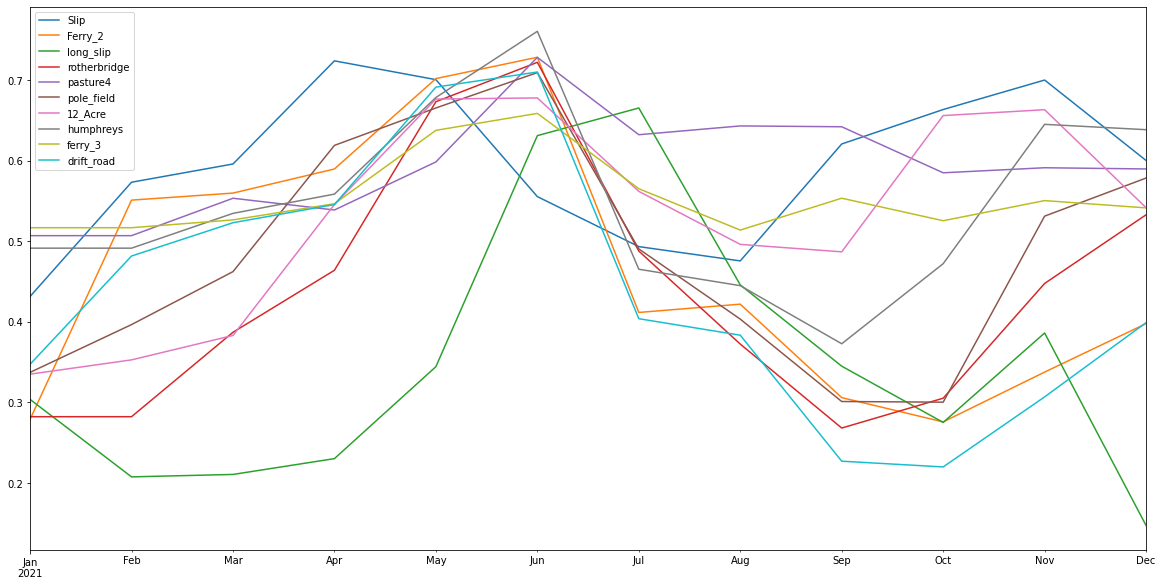

In [36]:
df_hampel_smooth.iloc[:,:10].plot(figsize=(20,10))

<AxesSubplot:>

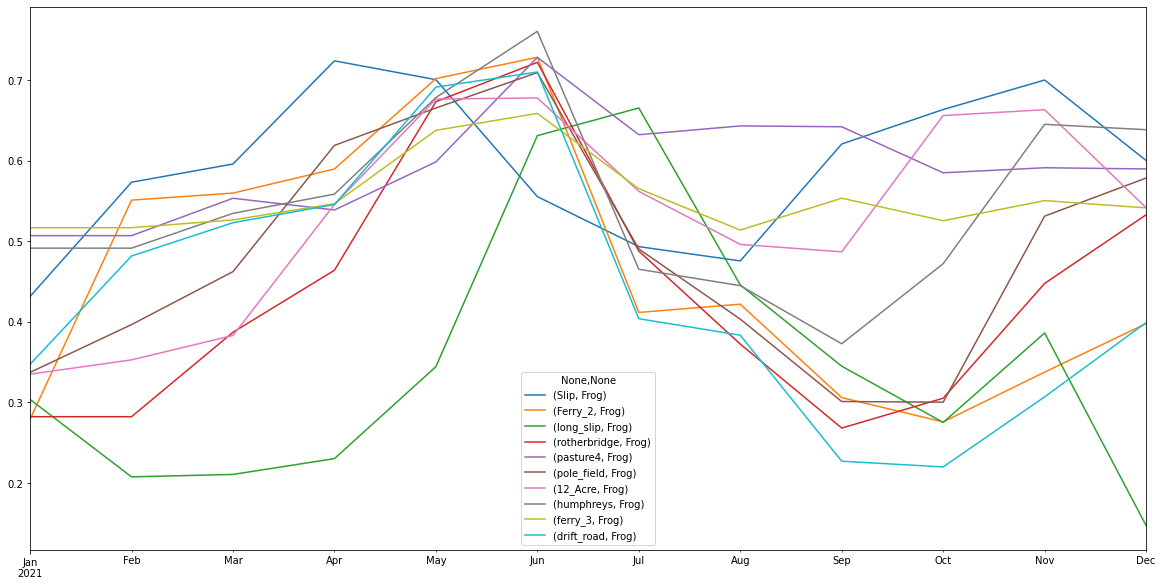

In [30]:
df_mul.iloc[:,:10].plot(figsize=(20,10))

In [42]:
import plotly.express as px
df_plot = df_mul.loc[:,(slice(None),'Selsey')]
fied_names = df_plot.columns.get_level_values(0)
df_plot.columns = fied_names

fig = px.line(df_plot, x=df_plot.index, y=df_plot.columns , range_y=[0,1])
fig.show(figsize=(20,10))

<AxesSubplot:>

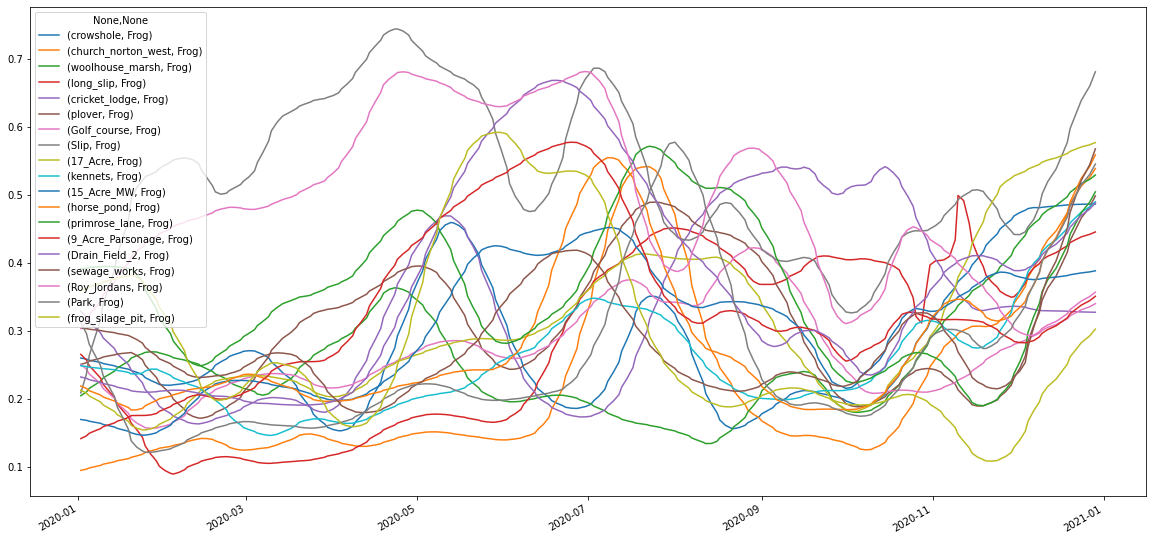

In [85]:
df_mul.loc[:,(slice(None),'Frog')].plot(figsize=(20,10))
# print(df_mul.loc[:,(slice(None),'Frog')])

In [29]:
# https://tech.gorilla.co/how-can-we-quantify-similarity-between-time-series-ed1d0b633ca0
# https://tech.gorilla.co/customer-segmentation-in-utility-retail-using-time-series-clustering-2640d0cfe8e0
# https://github.com/wannesm/dtaidistance

import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering 
import bz2
import numpy as np

def calc_euclidean(actual, predic):
    return np.sqrt(np.sum((actual - predic) ** 2))

def calc_mape(actual, predic):
    return np.mean(np.abs((actual - predic) / actual))

def calc_correlation(actual, predic):
    a_diff = actual - np.mean(actual)
    p_diff = predic - np.mean(predic)
    numerator = np.sum(a_diff * p_diff)
    denominator = np.sqrt(np.sum(a_diff ** 2)) * np.sqrt(np.sum(p_diff ** 2))
    return numerator / denominator
class CompressionBasedDissimilarity(object):

    def __init__(self, n_letters=7):
        self.bins = None
        self.n_letters = n_letters

    def set_bins(self, bins):
        self.bins = bins

    def sax_bins(self, all_values):
        bins = np.percentile(
            all_values[all_values > 0], np.linspace(0, 100, self.n_letters + 1)
        )
        bins[0] = 0
        bins[-1] = 1e1000
        return bins

    @staticmethod
    def sax_transform(all_values, bins):
        indices = np.digitize(all_values, bins) - 1
        alphabet = np.array([*("abcdefghijklmnopqrstuvwxyz"[:len(bins) - 1])])
        text = "".join(alphabet[indices])
        return str.encode(text)

    def calculate(self, m, n):
        if self.bins is None:
            m_bins = self.sax_bins(m)
            n_bins = self.sax_bins(n)
        else:
            m_bins = n_bins = self.bins
        m = self.sax_transform(m, m_bins)
        n = self.sax_transform(n, n_bins)
        len_m = len(bz2.compress(m))
        len_n = len(bz2.compress(n))
        len_combined = len(bz2.compress(m + n))
        return len_combined / (len_m + len_n)

def get_clusters(data: pd.DataFrame, metric: str, threshold: float):
    if metric == "corr":
        affinity = 1 - data.corr()
    elif metric == "mape":
        affinity = data.corr(calc_mape)
        affinity.values[tuple([np.arange(affinity.shape[0])]*2)] = 0
    elif metric == "eucl":
        affinity = data.corr(calc_euclidean)
        affinity.values[tuple([np.arange(affinity.shape[0])]*2)] = 0
    elif metric == "cbd":
        cbd = CompressionBasedDissimilarity()
        cbd.set_bins(cbd.sax_bins(data.values.reshape(-1)))
        affinity = data.corr(cbd.calculate)
        affinity.values[tuple([np.arange(affinity.shape[0])]*2)] = 0.5
    else:
      raise Exception("Unknown similarity metric.")

    # model = AgglomerativeClustering(n_clusters=None,
    #                                 affinity="precomputed",
    #                                 linkage="average",
    #                                 distance_threshold=threshold,
    #                                 compute_distances=True)

    model = AgglomerativeClustering(n_clusters=5,
                                    affinity="precomputed",
                                    linkage="average",
                                    distance_threshold=None,
                                    compute_distances=True)

    return model.fit(affinity)

In [106]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

cluster_model = get_clusters(clean_dataset(df_hampel_smooth), "eucl", 0.2)
labels = cluster_model.labels_

In [107]:
display(len(labels) , df_hampel_smooth.iloc[:,:10].columns)

list_tuples2 = list(zip(set(list_fields),list_cropids,labels))

display(df_hampel_smooth.head())

df_mul = df_hampel_smooth.copy()

df_mul.columns = pd.MultiIndex.from_tuples(list_tuples2)
display(df_mul.tail())

4150

Int64Index([81920, 81921, 81922, 81923, 81924, 81925, 81926, 81927, 81928,
            81929],
           dtype='int64')

,81920,81921,81922,81923,81924,81925,81926,81927,81928,81929,...,81910,81911,81912,81913,81914,81915,81916,81917,81918,81919
2017-04-01,0.088111,0.080377,0.143472,0.102075,0.145725,0.134442,0.168177,0.128852,0.142412,0.149778,...,0.074888,0.082733,0.084753,0.103334,0.088079,0.078354,0.082240,0.075921,0.130208,0.133599
2017-04-08,0.091662,0.085430,0.144397,0.107653,0.143195,0.135262,0.163940,0.125385,0.135520,0.150884,...,0.080841,0.086826,0.086071,0.104243,0.091915,0.081590,0.088694,0.079929,0.129708,0.136597
2017-04-11,0.094846,0.090124,0.145110,0.112794,0.140838,0.136245,0.159987,0.121944,0.128853,0.151844,...,0.086419,0.090393,0.086975,0.104790,0.095484,0.084569,0.094604,0.083403,0.128951,0.139230
2017-04-18,0.097979,0.094473,0.146210,0.117695,0.138763,0.137367,0.156601,0.118726,0.122757,0.152922,...,0.091859,0.093733,0.087578,0.105027,0.098963,0.087584,0.100156,0.086559,0.128467,0.141701
2017-04-21,0.101292,0.097519,0.146472,0.121544,0.136957,0.138796,0.153713,0.115719,0.118787,0.153325,...,0.096032,0.095353,0.086393,0.103376,0.101149,0.089804,0.103652,0.088411,0.126752,0.142750


,81920,81921,81922,81923,81924,81925,81926,81927,81928,81929,...,81910,81911,81912,81913,81914,81915,81916,81917,81918,81919
,1,1,1,1,1,1,1,1,1,1,...,5,5,5,5,5,5,5,5,5,5
,3,3,4,4,4,4,4,3,3,4,...,3,3,3,3,3,3,3,3,4,4
2017-11-19,0.135054,0.138449,0.150962,0.147195,0.205322,0.205681,0.231789,0.179802,0.175212,0.203895,...,0.136749,0.133026,0.124647,0.134669,0.248933,0.138291,0.139079,0.177817,0.171173,0.179480
2017-11-22,0.137574,0.138032,0.156083,0.146544,0.230286,0.236000,0.272543,0.199207,0.189745,0.192502,...,0.137105,0.132383,0.124297,0.134466,0.276039,0.138873,0.140354,0.203099,0.175792,0.184136
2017-11-24,0.140467,0.138481,0.161212,0.145881,0.253986,0.265442,0.311017,0.217724,0.204055,0.180537,...,0.137883,0.132610,0.124674,0.134893,0.303055,0.139505,0.142100,0.228331,0.179928,0.188286
2017-11-27,0.143509,0.138840,0.166297,0.144927,0.278292,0.295234,0.350330,0.236703,0.218649,0.167893,...,0.138692,0.132780,0.125235,0.135433,0.330366,0.140199,0.143899,0.254081,0.183971,0.192244
2017-11-29,0.146881,0.139393,0.171608,0.143726,0.302934,0.325298,0.390117,0.255973,0.233900,0.154369,...,0.139721,0.133157,0.126092,0.136209,0.357516,0.140995,0.145872,0.280829,0.188007,0.195845


<AxesSubplot:>

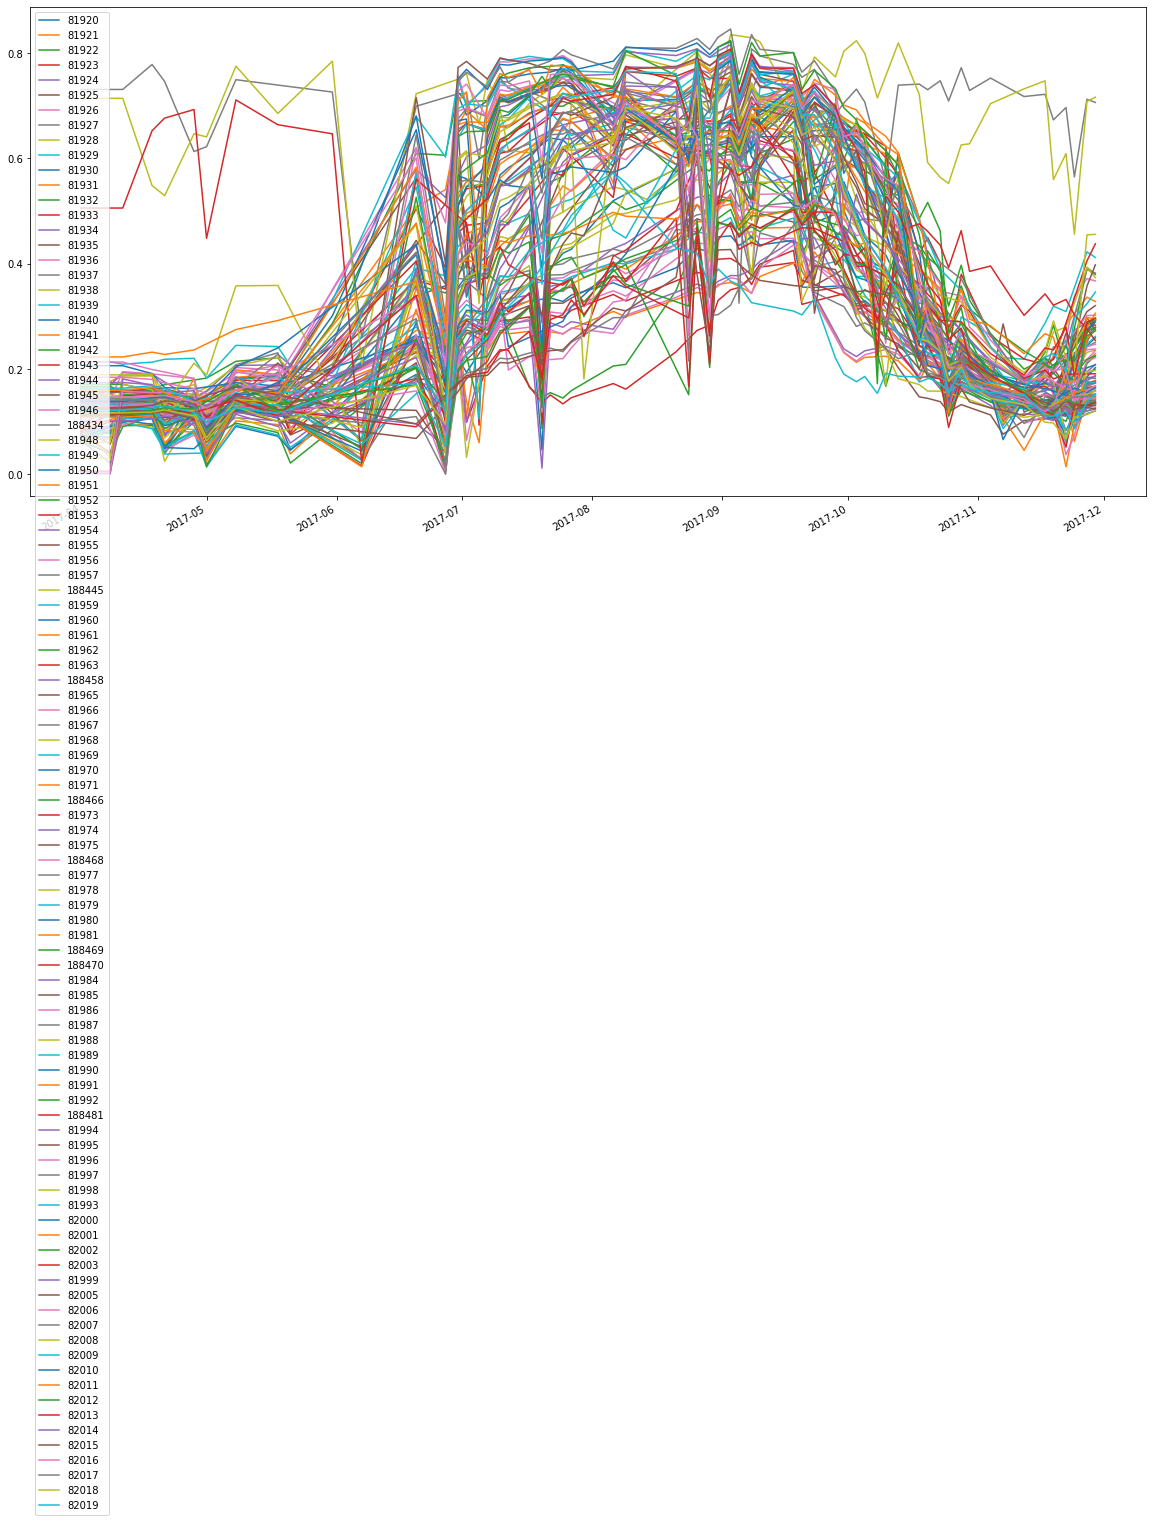

In [112]:

df_int.iloc[:,:100].plot(figsize=(20,10))

In [55]:
df=pd.DataFrame({'a':[1,2,3],'b':[4,5,6]})

columns=[('c','a'),('d','b')]

df.columns=pd.MultiIndex.from_tuples(columns)
display(df)

,c,d
,a,b
0,1,4
1,2,5
2,3,6


In [54]:
df = pd.Series(np.random.rand(3), index=["a","b","c"]).to_frame().T
display(df)
df.columns = pd.MultiIndex.from_product([["1"], df.columns])
display(df)

,a,b,c
0,0.088833,0.857578,0.90133


1                   
          a         b        c
0  0.088833  0.857578  0.90133